The aim here is to compare the recovery (in terms of average summed synapse strength onto excitatory cells and firing rate distributions of excitatory cells) of a network of HVC RA-projectors and interneurons following a 50% perturbation of the RA-projectors.

Here, we compare the recovery under 3 distinct sets of plasticity rules:

1. burst timing-dependent plasticity + single-cell firing rate upper bound + population-level firing rate rule
2. burst timing-dependent plasticity + single-cell firing rate (asym about setpoint)
3. burst timing-dependent plasticity + population-level firing rate rule

In [131]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

%matplotlib inline
from copy import deepcopy as copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
from scipy import stats
import scipy.io as sio
import pandas as pd
import pickle
from collections import OrderedDict
from scipy.ndimage.interpolation import shift
from functools import reduce
import time
import re
from scipy.special import comb
import time
import asyncio

from aux import Generic, bin_occurrences, safe_apply_stat, flatten
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG
from utils.general import *
from utils.file_io import *

dt = 0.22e-3

In [2]:
def save_fig(fig, path, name):
    if not os.path.exists(path):
        os.makedirs(path)
    fig.savefig(os.path.join(path, name))

In [3]:
def get_equally_spaced_colors(n, cmap='autumn'):
    cmap = plt.get_cmap(cmap)
    colors = cmap(np.linspace(0, 1, n))
    return [matplotlib.colors.rgb2hex(rgba) for rgba in colors]

In [4]:
def process_single_activation(exc_raster, n):
    # extract first spikes
    first_spk_times = np.nan * np.ones(n)
    for i in range(exc_raster.shape[1]):
        nrn_idx = int(exc_raster[1, i])
        if np.isnan(first_spk_times[nrn_idx]):
            first_spk_times[nrn_idx] = exc_raster[0, i]
    return first_spk_times

In [5]:
def load_exp_data(direc, cut=None, layer_size=25, name_frags=[], reverse=False):
    file_names = [f for f in sorted(all_files_from_dir(direc))]
    file_names = [f for f in filter_list_by_name_frags(file_names, name_frags)]
    if reverse:
        file_names = [f for f in reversed(file_names)]
    if cut is not None:
        file_names = file_names[:cut]
        
    included_cell_mask = None
    file_name_count = range(0, len(file_names))
    for i_f in file_name_count:
        file = file_names[i_f]
        
        if i_f == 0:
            loaded = sio.loadmat(os.path.join(direc, file))
        
        def lazy_load():
            loaded = sio.loadmat(os.path.join(direc, file))

            summed_incoming_weights = loaded['w_r_e_summed']
            summed_incoming_weights_e_i = loaded['w_r_e_i_summed']

            try:
                exc_cells_initially_active = loaded['exc_raster']
                exc_cells_newly_active = None
            except KeyError as e:
                exc_cells_initially_active = loaded['exc_cells_initially_active'].astype(float)
                exc_cells_newly_active = loaded['exc_cells_newly_active'].astype(float)
                exc_cells_initially_active[0, :] = exc_cells_initially_active[0, :] * dt
                if exc_cells_newly_active is not None and exc_cells_newly_active.shape[0] > 0:
                    exc_cells_newly_active[0, :] = exc_cells_newly_active[0, :] * dt
            inh_raster = loaded['inh_raster']

            try:
                surviving_cell_indices = loaded['surviving_cell_indices'][0].astype(bool)
            except KeyError as e:
                surviving_cell_indices = np.ones(summed_incoming_weights.shape[0], dtype=bool)

            summed_incoming_weights = summed_incoming_weights[(surviving_cell_indices).nonzero()[0]]

            first_spk_times = process_single_activation(exc_cells_initially_active, 2000)

            last_layer_active = 0
            layer_weights = []

            for i in range(0, len(first_spk_times), layer_size):
                layer_active = np.any(~np.isnan(first_spk_times[i:i+layer_size]))
                if layer_active:
                    last_layer_active = i/layer_size

                layer_weight = np.sum(summed_incoming_weights[i:(i + layer_size)])
                layer_weights.append(layer_weight)

            data = {
                'index': i_f,
                'last_layer_active': last_layer_active,
                'first_spk_times': first_spk_times,
                
                'mean_incoming_summed_weights': np.mean(summed_incoming_weights),
                'median_incoming_summed_weights': np.median(summed_incoming_weights),
                'std_incoming_summed_weights': np.std(summed_incoming_weights),
                'summed_incoming_weights': summed_incoming_weights,
                
                'mean_incoming_summed_weights_e_i': np.mean(summed_incoming_weights_e_i),
                'median_incoming_summed_weights_e_i': np.median(summed_incoming_weights_e_i),
                'std_incoming_summed_weights_e_i': np.std(summed_incoming_weights_e_i),
                'summed_incoming_weights_e_i': summed_incoming_weights_e_i,
                
                'exc_cells_initially_active': exc_cells_initially_active,
                'exc_cells_newly_active': exc_cells_newly_active,
                'inh_raster': inh_raster,
                'freqs': loaded['freqs'][0],
                'spk_bins': loaded['spk_bins'][0],
                'surviving_cell_indices': surviving_cell_indices,
            }
            return data
        yield i_f, lazy_load

In [6]:
def make_figure_1(name, timepoints = [0, 72, 73], verify_chain_timepoints=None):
    if type(name) is list:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), name)
    else:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), [name])
    
    colors = get_equally_spaced_colors(20, cmap='gist_ncar')
    
    def rendition_label(n):
        if n == 0:
            n = 1
            return f'{n}' + r'$^{st}$ rendition'
        else:
            return f'{n}' + r'$^{th}$ rendition'
        
    if verify_chain_timepoints is None:
        verify_chain_timepoints = np.arange(3)
    
    for d_idx, exp_dir_name in enumerate(sorted(all_dirs)):
        print(exp_dir_name)
        scale = 1.1
        
        timepoints_verified = np.zeros(len(verify_chain_timepoints))
        
        for i, load_data in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=['dropout_0']):
            if i in verify_chain_timepoints:
                data = load_data()
                timepoints_verified[i] = int(data['last_layer_active'] >= 39)
        if (np.sum(timepoints_verified) / len(timepoints_verified)) < 1.:
            continue
           
        fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12 * scale, 4 * scale))
        timepoint_names = [rendition_label(t * 10) for t in timepoints]
        j = 0
        
        for i, load_data in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=['dropout_0']):                
            if j < len(timepoints) and i == timepoints[j]:
                print(timepoints[j])
                data = load_data()
                exc_cells_initially_active = data['exc_cells_initially_active']
                exc_cells_newly_active = data['exc_cells_newly_active']
                inh_raster = data['inh_raster']

                if j == 0:
                    axs[j].scatter(exc_cells_initially_active[0, :] * 1000, exc_cells_initially_active[1, :], s=1, c='black', zorder=0, alpha=0.5)
                else:
                    axs[j].scatter(exc_cells_initially_active[0, :] * 1000, exc_cells_initially_active[1, :], s=1, c='black', zorder=0, alpha=0.5)
                    if exc_cells_newly_active is not None and len(exc_cells_newly_active) > 0:
                        axs[j].scatter(exc_cells_newly_active[0, :] * 1000, exc_cells_newly_active[1, :], s=1, c='green', zorder=1, alpha=1)

                if len(inh_raster) > 0:
                    axs[j].scatter(inh_raster[0, :] * 1000, inh_raster[1, :], s=1, c='blue', zorder=0, alpha=1)
                axs[j].set_ylim(200, 3000)
                axs[j].set_xlim(0.060 * 1000, 0.260 * 1000)
                axs[j].set_ylabel('Cell Index')
                axs[j].set_xlabel('Time (ms)')
                axs[j].title.set_text(f'{timepoint_names[j]}')
                set_font_size(axs[j], 16)
                j += 1
        
        fig.tight_layout()  
        save_fig(fig, './figures/paper/fig_1', f'{exp_dir_name}.png')
        

In [11]:
fr_only_name_frags = ['single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED', 'ALPHA_2_0_ALPHA_1_0.006']

In [ ]:
make_figure_1(fr_only_name_frags, timepoints=[0, 10, 50])

In [12]:
two_single_cell_rules_name_frags = ['single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED', 'ALPHA_2_0.0005_ALPHA_1_0.006']

In [ ]:
make_figure_1(two_single_cell_rules_name_frags, timepoints=[0, 10, 50])

In [61]:
def determine_recovered(names, timepoints, threshold=0.9):
    recovered_dir_names = []
    all_dirs = []
    for name in names:
        if type(names) is list:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        else:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
    all_recovery_pers = []
    all_last_layer_active_stats = []
    for i, exp_dir_names in enumerate(all_dirs):
        per_recovered_for_name = 0
        last_layer_actives_for_name = []
        for j, exp_dir_name in enumerate(exp_dir_names):
            print(exp_dir_name)
            n_active = 0
            n_count = 0
            last_layer_actives = []
            for i, data_load in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=[]):
                if i not in timepoints:
                    continue
                data = data_load()
                n_active += int(data['last_layer_active'] >= 79)
                last_layer_actives.append(data['last_layer_active'])
                n_count += 1
            last_layer_actives_for_name.append(np.mean(last_layer_actives))
            if n_active == 0:
                continue
            if n_active / n_count >= threshold:
                print('X')
                recovered_dir_names.append(exp_dir_name)
                per_recovered_for_name += 1
        per_recovered_for_name /= len(exp_dir_names)
        all_recovery_pers.append(per_recovered_for_name)
        mean_last_layer = np.mean(last_layer_actives_for_name)
        sem_last_layer = np.std(last_layer_actives_for_name) / np.sqrt(len(last_layer_actives_for_name))
        all_last_layer_active_stats.append((mean_last_layer, sem_last_layer))
        
    return recovered_dir_names, all_recovery_pers, all_last_layer_active_stats


In [62]:
def iter_range(r, n):
    if n == 1:
        yield (0, r[0])
    else:
        for i in range(n):
            yield (i, i * (r[1] - r[0]) / (n - 1) + r[0])

In [63]:
def real_to_str(real):
    s = f'{real}'
    first_sig_digit_idx = re.search('[1-9]', s)
    if not first_sig_digit_idx:
        return s
    
    x = s.rfind('00')
    while x >= 0 and x > first_sig_digit_idx.start():
        s = s[:x]
        x = s.rfind('00')
    return s

In [64]:
recovered_exp_names, all_recovery_pers, all_last_layer_active_stats = determine_recovered([
    fr_only_name_frags,
    two_single_cell_rules_name_frags,
], np.arange(50, 60))

single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2081_ALPHA_2_0_ALPHA_1_0.006_ff_0.7_eir_0.5_ier_0.0_2021-12-08--03:11--15:7624
X
single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2062_ALPHA_2_0_ALPHA_1_0.006_ff_0.7_eir_0.5_ier_0.0_2021-12-07--22:22--34:2403
X
single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2063_ALPHA_2_0_ALPHA_1_0.006_ff_0.7_eir_0.5_ier_0.0_2021-12-07--22:22--34:0508
X
single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2083_ALPHA_2_0_ALPHA_1_0.006_ff_0.7_eir_0.5_ier_0.0_2021-12-08--03:11--15:5917
X
single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2061_ALPHA_2_0_ALPHA_1_0.006_ff_0.7_eir_0.5_ier_0.0_2021-12-07--22:22--34:7565
X
single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2067_ALPHA_2_0_ALPHA_1_0.006_ff_0.7_eir_0.5_ier_0.0_2021-12-07--23:05--27:1912
X
single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2060_ALPHA_2_0_ALPHA_1_0.006_ff_0.7_eir_0.5_ier_0.0_2021-12-07--22:22--34:1801
X
single_silent_only__SYN_PROP_DIST_1.3_DRO

In [17]:
all_recovery_pers

[0.88, 1.0]

In [18]:
def make_figure_2_plot(names, labels, condition_colors, file_name_ext='', ylim1=None, ylim2=None, cap=99, timepoints=[], offsets=[], vertical_spacing=1.):
    
    scale = 1.8
    fig, axs = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(6 * scale, 5 * scale))
    
    all_dirs = []
    for name in names:
        if type(name) is not list:
            name = [name]
        print(name)
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        
    timepoints = np.array(timepoints)
        
    for idx, exp_dir_names in enumerate(all_dirs):
        all_weights_for_dir_name = []
        all_weights_e_i_for_dir_name = []
        
        for j, exp_dir_name in enumerate(exp_dir_names):
            print(exp_dir_name)
#             if exp_dir_name not in recovered_exp_names:
#                 continue
#             if j > 10:
#                 continue
            
            all_mean_incoming_summed_weights = []
            all_std_incoming_summed_weights = []
            all_mean_incoming_summed_weights_e_i = []
            all_std_incoming_summed_weights_e_i = []
            baseline_mean = None
            baseline_std = None
            baseline_mean_e_i = None
            baseline_std_e_i = None

            for i, data_load in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=[]):
                if i not in timepoints:
                    continue
                data = data_load()
                
                all_mean_incoming_summed_weights.append(data['mean_incoming_summed_weights'])
                all_std_incoming_summed_weights.append(data['std_incoming_summed_weights'])
                all_mean_incoming_summed_weights_e_i.append(data['mean_incoming_summed_weights_e_i'])
                all_std_incoming_summed_weights_e_i.append(data['std_incoming_summed_weights_e_i'])

                if i == offsets[idx]:
                    baseline_mean = data['mean_incoming_summed_weights']
                    baseline_std = data['std_incoming_summed_weights']
                    baseline_mean_e_i = data['mean_incoming_summed_weights_e_i']
                    baseline_std_e_i = data['std_incoming_summed_weights_e_i']
                       
            all_mean_incoming_summed_weights = np.array(all_mean_incoming_summed_weights) / baseline_mean
            all_std_incoming_summed_weights = np.array(all_std_incoming_summed_weights) / baseline_mean
            all_mean_incoming_summed_weights_e_i = np.array(all_mean_incoming_summed_weights_e_i) / baseline_mean_e_i
            all_std_incoming_summed_weights_e_i = np.array(all_std_incoming_summed_weights_e_i) / baseline_mean_e_i
                
            all_weights_for_dir_name.append(all_mean_incoming_summed_weights)
            all_weights_e_i_for_dir_name.append(all_mean_incoming_summed_weights_e_i)
            
            #axs[0].plot(timepoints[:len(all_mean_incoming_summed_weights)] * 10, all_mean_incoming_summed_weights, color=condition_colors[idx], lw=0.5, zorder=-1)
        
        if len(all_weights_for_dir_name) == 0:
            continue
        
        e_e_means = safe_apply_stat(all_weights_for_dir_name, np.mean)
        e_e_sems = safe_apply_stat(all_weights_for_dir_name, lambda x: np.std(x) / np.sqrt(len(x)))
        e_i_means = safe_apply_stat(all_weights_e_i_for_dir_name, np.mean)
        e_i_sems = safe_apply_stat(all_weights_e_i_for_dir_name, lambda x: np.std(x) / np.sqrt(len(x)))

        y_disp = vertical_spacing * idx

        axs[0].fill_between(
            timepoints * 10,
            e_e_means - e_e_sems + y_disp,
            e_e_means + e_e_sems + y_disp,
            color=condition_colors[idx], alpha=0.2)
        axs[0].plot(timepoints * 10, e_e_means + y_disp, lw=1.5, color=condition_colors[idx], label=labels[idx])
        axs[1].fill_between(
            timepoints * 10,
            e_i_means - e_i_sems + y_disp,
            e_i_means + e_i_sems + y_disp,
            color=condition_colors[idx], alpha=0.2)
        axs[1].plot(timepoints * 10, e_i_means + y_disp, lw=1.5, color=condition_colors[idx], label=labels[idx])

        axs[0].set_ylabel(r'Mean E$\rightarrow$E summed' + '\nsynapse strength')
        axs[1].set_ylabel(r'Mean E$\rightarrow$I summed' + '\nsynapse strength')
        if ylim1 is not None:
                axs[0].set_ylim(ylim1[0], ylim1[1])
        if ylim2 is not None:
                axs[1].set_ylim(ylim2[0], ylim2[1])
                
        y_ticks = []
        y_tick_labels = []
        for i in range(len(names)):
            y_ticks.append(vertical_spacing * i + 0.5)
            y_ticks.append(vertical_spacing * i + 1)
            y_ticks.append(vertical_spacing * i + 1.5)
            y_tick_labels.append(0.5)
            y_tick_labels.append(1)
            y_tick_labels.append(1.5)
                
        for i in range(2):
            axs[i].set_xlim(0, (cap - 1) * 10)
            axs[i].set_xlabel('Rendition number')
            axs[i].tick_params(right=True, labelright=True)
            set_font_size(axs[i], 16)
        
#             axs[i].set_yticks(y_ticks)
#             axs[i].set_yticklabels(y_tick_labels)
            
        axs[0].legend(loc='upper right')
        fig.tight_layout()
        save_fig(fig, './figures/paper/fig_2', f'mean_plot_{file_name_ext}.png')

['single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED', 'ALPHA_2_0_ALPHA_1_0.006']
['single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED', 'ALPHA_2_0.0005_ALPHA_1_0.006']
single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2081_ALPHA_2_0_ALPHA_1_0.006_ff_0.7_eir_0.5_ier_0.0_2021-12-08--03:11--15:7624
single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2062_ALPHA_2_0_ALPHA_1_0.006_ff_0.7_eir_0.5_ier_0.0_2021-12-07--22:22--34:2403
single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2063_ALPHA_2_0_ALPHA_1_0.006_ff_0.7_eir_0.5_ier_0.0_2021-12-07--22:22--34:0508
single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2083_ALPHA_2_0_ALPHA_1_0.006_ff_0.7_eir_0.5_ier_0.0_2021-12-08--03:11--15:5917
single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2061_ALPHA_2_0_ALPHA_1_0.006_ff_0.7_eir_0.5_ier_0.0_2021-12-07--22:22--34:7565
single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2067_ALPHA_2_0_ALPHA_1_0.006_ff_0.7_eir_0.5_ier_0.0_2021-12-07--23:05--27:1912
single_sile

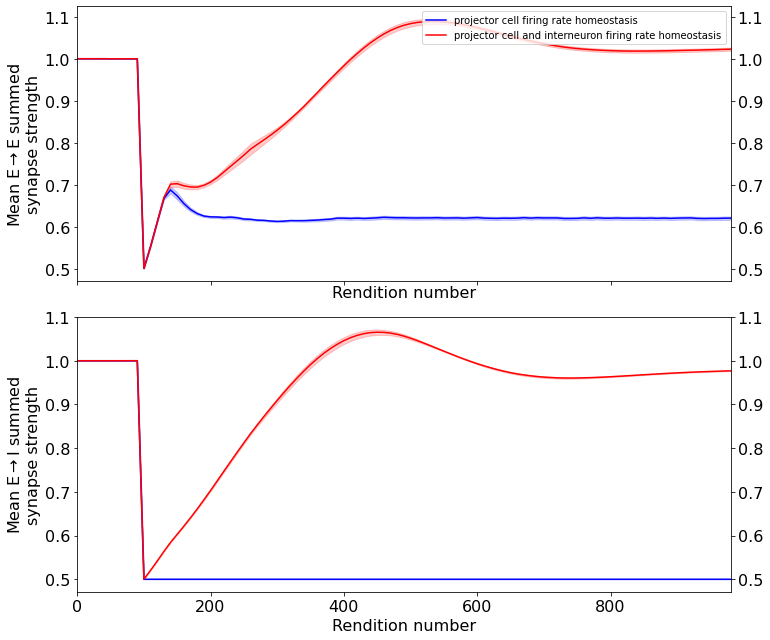

In [137]:
timepoints = np.arange(0, 99, 1)

make_figure_2_plot([
    fr_only_name_frags,
    two_single_cell_rules_name_frags,
], labels=[
    'projector cell firing rate homeostasis',
    'projector cell and interneuron firing rate homeostasis',
], condition_colors=['blue', 'red'], timepoints=timepoints, cap=99, offsets=np.zeros(3), vertical_spacing=0.,
file_name_ext='all_3_silent')

In [54]:
recovered_exp_names = [x.strip() for x in recovered_exp_names]


In [115]:
def extract_weight_dist_stats(names, recovered_exp_names, timepoints):
    all_dirs = []
    for name in names:
        if type(names) is list:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        else:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
    
    all_weight_dist_info = []
    all_summed_weights = []
    
    for i, exp_dir_names in enumerate(all_dirs):
        
        summed_weights_for_group = [[] for t in timepoints]
        weight_freqs_for_group = [[] for t in timepoints]
        weight_bins = [[] for t in timepoints]
        
        for j, exp_dir_name in enumerate(exp_dir_names):
            if exp_dir_name not in recovered_exp_names:
                continue
            print(exp_dir_name)
            
            t_ctr = 0
            for k, data_load in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=[]):
                if k not in timepoints:
                    continue
                data = data_load()
                
                summed_incoming_weights = data['summed_incoming_weights']
                summed_weights_for_group[t_ctr].append(summed_incoming_weights)
                
                bins, freqs = bin_occurrences(summed_incoming_weights, max_val=0.0035, bin_size=0.00005)
                weight_bins[t_ctr] = bins
                weight_freqs_for_group[t_ctr].append(freqs)
                
                t_ctr += 1
        
        mean_weight_dists = []
        std_weight_dists = []
        summed_weight_bins = []
        
        mean_summed_incoming_weights = []
        std_summed_incoming_weights = []
        
        for i_t, t in enumerate(timepoints):
            mean_weight_dists.append(np.nanmean(weight_freqs_for_group[i_t], axis=0))
            std_weight_dists.append(np.nanstd(weight_freqs_for_group[i_t], axis=0))
            summed_weight_bins.append(weight_bins[i_t])
            
            mean_summed_incoming_weights.append(np.nanmean(summed_weights_for_group[i_t], axis=0).flatten())
            std_summed_incoming_weights.append(np.nanstd(summed_weights_for_group[i_t], axis=0).flatten())
                
        all_weight_dist_info.append({
            'mean_weight_dists': mean_weight_dists,
            'std_weight_dists': std_weight_dists,
            'summed_weight_bins': summed_weight_bins[0][0],
            'mean_summed_incoming_weights': mean_summed_incoming_weights,
            'std_summed_incoming_weights': std_summed_incoming_weights,
        })
    return all_weight_dist_info

In [116]:
all_weight_dist_info = extract_weight_dist_stats([
    fr_only_name_frags,
    two_single_cell_rules_name_frags,
], recovered_exp_names, [0, 10, 50])

single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2081_ALPHA_2_0_ALPHA_1_0.006_ff_0.7_eir_0.5_ier_0.0_2021-12-08--03:11--15:7624
single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2062_ALPHA_2_0_ALPHA_1_0.006_ff_0.7_eir_0.5_ier_0.0_2021-12-07--22:22--34:2403
single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2063_ALPHA_2_0_ALPHA_1_0.006_ff_0.7_eir_0.5_ier_0.0_2021-12-07--22:22--34:0508
single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2083_ALPHA_2_0_ALPHA_1_0.006_ff_0.7_eir_0.5_ier_0.0_2021-12-08--03:11--15:5917
single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2061_ALPHA_2_0_ALPHA_1_0.006_ff_0.7_eir_0.5_ier_0.0_2021-12-07--22:22--34:7565
single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2067_ALPHA_2_0_ALPHA_1_0.006_ff_0.7_eir_0.5_ier_0.0_2021-12-07--23:05--27:1912
single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2060_ALPHA_2_0_ALPHA_1_0.006_ff_0.7_eir_0.5_ier_0.0_2021-12-07--22:22--34:1801
single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED

In [103]:
pickle.dump(all_weight_dist_info, open('parsed_data_3.p', 'wb'))


In [104]:
# aggregate_weight_dist_data = pickle.load(open('./parsed_data_3.p', 'rb'))
# print(aggregate_weight_dist_data)

(0.0, 0.0009)

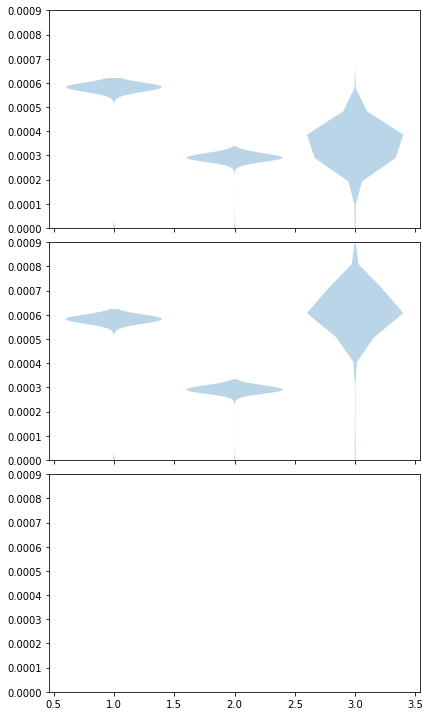

In [124]:
scale = 1
fig, axs = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(6 * scale, 10 * scale))

for k, dist_data_for_name in enumerate(all_weight_dist_info):
    if len(dist_data_for_name) > 0:
        ax = axs[k]
        ax.violinplot(dist_data_for_name['mean_summed_incoming_weights'], showmeans=False, showextrema=False, widths=0.8 * np.ones(3))
#         for i_t, dist_data_for_tp in enumerate(dist_data_for_name):
            
#             ax.fill_between(dist_data['summed_weight_bins'], dist_data['mean_weight_dists_initial'] - dist_data['std_weight_dists_initial'], dist_data['mean_weight_dists_initial'] + dist_data['std_weight_dists_initial'], color='black', alpha=0.2)
#             ax.plot(dist_data['summed_weight_bins'], dist_data['mean_weight_dists_initial'], color='black')
#             ax.fill_between(dist_data['summed_weight_bins'], dist_data['mean_weight_dists_final'] - dist_data['std_weight_dists_final'], dist_data['mean_weight_dists_final'] + dist_data['std_weight_dists_final'], color='red', alpha=0.2)
#             ax.plot(dist_data['summed_weight_bins'], dist_data['mean_weight_dists_final'], color='red')
fig.tight_layout()
ax.set_ylim(0, 0.0009)

In [153]:
def make_figure_3(names, ylim=(0, 8), trials=[3], timepoints = [0, 10, 12, 299]):    
    all_dirs = []
    for name in names:
        if type(name) is list:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        else:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
        
    spaced_colors = ['#ff1717', '#d117ff', '#171bff']
    labels = [
        'unperturbed',
        'perturbed',
        '100th rendition',
        '1900th rendition',
    ]
    
    for i_t in trials:
        scale = 1.1
        fig = plt.figure(constrained_layout=True, figsize=(25 * scale, 10 * scale))
        gs = gridspec.GridSpec(ncols=18, nrows=6, figure=fig)
       
        def create_split_freq_plot(row_start, row_end, col_start, fig, gs):
            sub_axs = [
                fig.add_subplot(gs[row_start:row_end, col_start]),
                fig.add_subplot(gs[row_start:row_end, (col_start+1):(col_start+6)])
            ]
            sub_axs[1].yaxis.tick_right()
            sub_axs[0].tick_params(bottom=False, labelbottom=False)
            sub_axs[0].set_ylabel('Number neurons')
            sub_axs[0].set_xlim(-1.5, 1.5)
            sub_axs[1].set_xlim(0.5, 40)
            sub_axs[0].set_xlabel('Silent')
            sub_axs[0].spines['right'].set_visible(False)
            sub_axs[0].spines['top'].set_visible(False)
            sub_axs[1].spines['left'].set_visible(False)
            sub_axs[1].spines['top'].set_visible(False)
            return sub_axs
            

        col_1_axs = [create_split_freq_plot(i, i+2, 6, fig, gs) for i in range(0, 6, 2)]
        col_2_axs = [create_split_freq_plot(i, i+2, 12, fig, gs) for i in range(0, 6, 2)]
        
        axs = [
            [create_split_freq_plot(0, 6, 0, fig, gs)],
            col_1_axs,
            col_2_axs,
        ]
        
        spk_bins_zero = None
        freqs_zero = None
        spk_bins_i_zero = None
        freqs_i_zero = None
        
        for idx, exp_dir_names in enumerate(all_dirs):
            j = 0
            exp_dir_names = sorted(exp_dir_names, key=lambda x: x[-4:])
            for i, data_load in load_exp_data(os.path.join('./robustness', exp_dir_names[i_t]), name_frags=['dropout_0']):
                if j < len(timepoints) and i == timepoints[j]:
                    data = data_load()
 
                    if j >= 1:
                        if idx == 0:
                            axs[j][idx][0].bar(spk_bins_zero[:1], freqs_zero[:1], color='gray', alpha=0.2, zorder=-j, width=1, label=labels[0])
                            axs[j][idx][1].plot(spk_bins_zero[1:], freqs_zero[1:], color='gray', alpha=1., zorder=-j, lw=2.5, label=labels[0])
                            
                            axs[j][idx][1].plot(spk_bins_i_zero, freqs_i_zero, '--', color='gray', alpha=1., zorder=-j, lw=2.5, label=labels[0] + ' inh')
                        else:
                            axs[j][idx][0].bar(spk_bins_zero[:1], freqs_zero[:1], color='gray', alpha=0.2, zorder=-j, width=1)
                            axs[j][idx][1].plot(spk_bins_zero[1:], freqs_zero[1:], color='gray', alpha=1., zorder=-j, lw=2.5)
                            
                            axs[j][idx][1].plot(spk_bins_i_zero, freqs_i_zero, '--', color='gray', alpha=1., zorder=-j, lw=2.5)

                    spk_bins = data['spk_bins']
                    freqs = data['freqs']
                    spks_for_i_cells = data['inh_raster']
                    if len(spks_for_i_cells) > 0:
                        spks_for_i_cells = spks_for_i_cells[1]
                        cell_labels, spks_i = bin_occurrences(spks_for_i_cells, min_val=2000, max_val=3000, bin_size=1)
                        spk_bins_i, freqs_i = bin_occurrences(spks_i, max_val=100, bin_size=1)
                    else:
                        spk_bins_i, freqs_i = (np.zeros(100), np.zeros(100))
                    
                    if j == 0:
                        spk_bins_zero = spk_bins
                        freqs_zero = freqs
                        spk_bins_i_zero = spk_bins_i
                        freqs_i_zero = freqs_i

                    if j >= 1 or (j == 0 and idx == 0):
                        color = 'black' if j < 1 else spaced_colors[idx]
                        if idx == 0:
                            axs[j][idx][0].bar(spk_bins[:1], freqs[:1], color=color, alpha=0.7, zorder=-j, width=1, label=labels[j])
                            axs[j][idx][1].plot(spk_bins[1:], freqs[1:], color=color, alpha=1., zorder=-j, lw=2.5, label=labels[j])
                            
                            axs[j][idx][1].plot(spk_bins_i, freqs_i, '--', color=color, alpha=1., zorder=-j, lw=2.5, label=labels[j] + ' inh')
                        else:
                            axs[j][idx][0].bar(spk_bins[:1], freqs[:1], color=color, alpha=0.7, zorder=-j, width=1)
                            axs[j][idx][1].plot(spk_bins[1:], freqs[1:], color=color, alpha=1., zorder=-j, lw=2.5)
                            
                            axs[j][idx][1].plot(spk_bins_i, freqs_i, '--', color=color, alpha=1., zorder=-j, lw=2.5)
            
                        if idx == (len(all_dirs) - 1):
                            axs[j][idx][1].set_xlabel('Spikes per neuron')
                        
                        if idx == 0:
                            axs[j][idx][1].legend(frameon=False)
                    
                        set_font_size(axs[j][idx][0], 18)
                        set_font_size(axs[j][idx][1], 18)

                    j += 1
        plt.locator_params(axis='x', nbins=5)
        save_fig(fig, './figures/paper/fig_3', f'trial_{i_t}.png')

## Figure 3: comparisons of the firing rate distributions of HVC(RA) cells for three cases: (1) single-cell rule + pop-level rule + STDP, (2) single-cell rule + STDP, (3) pop-level rule + STDP

### First run only

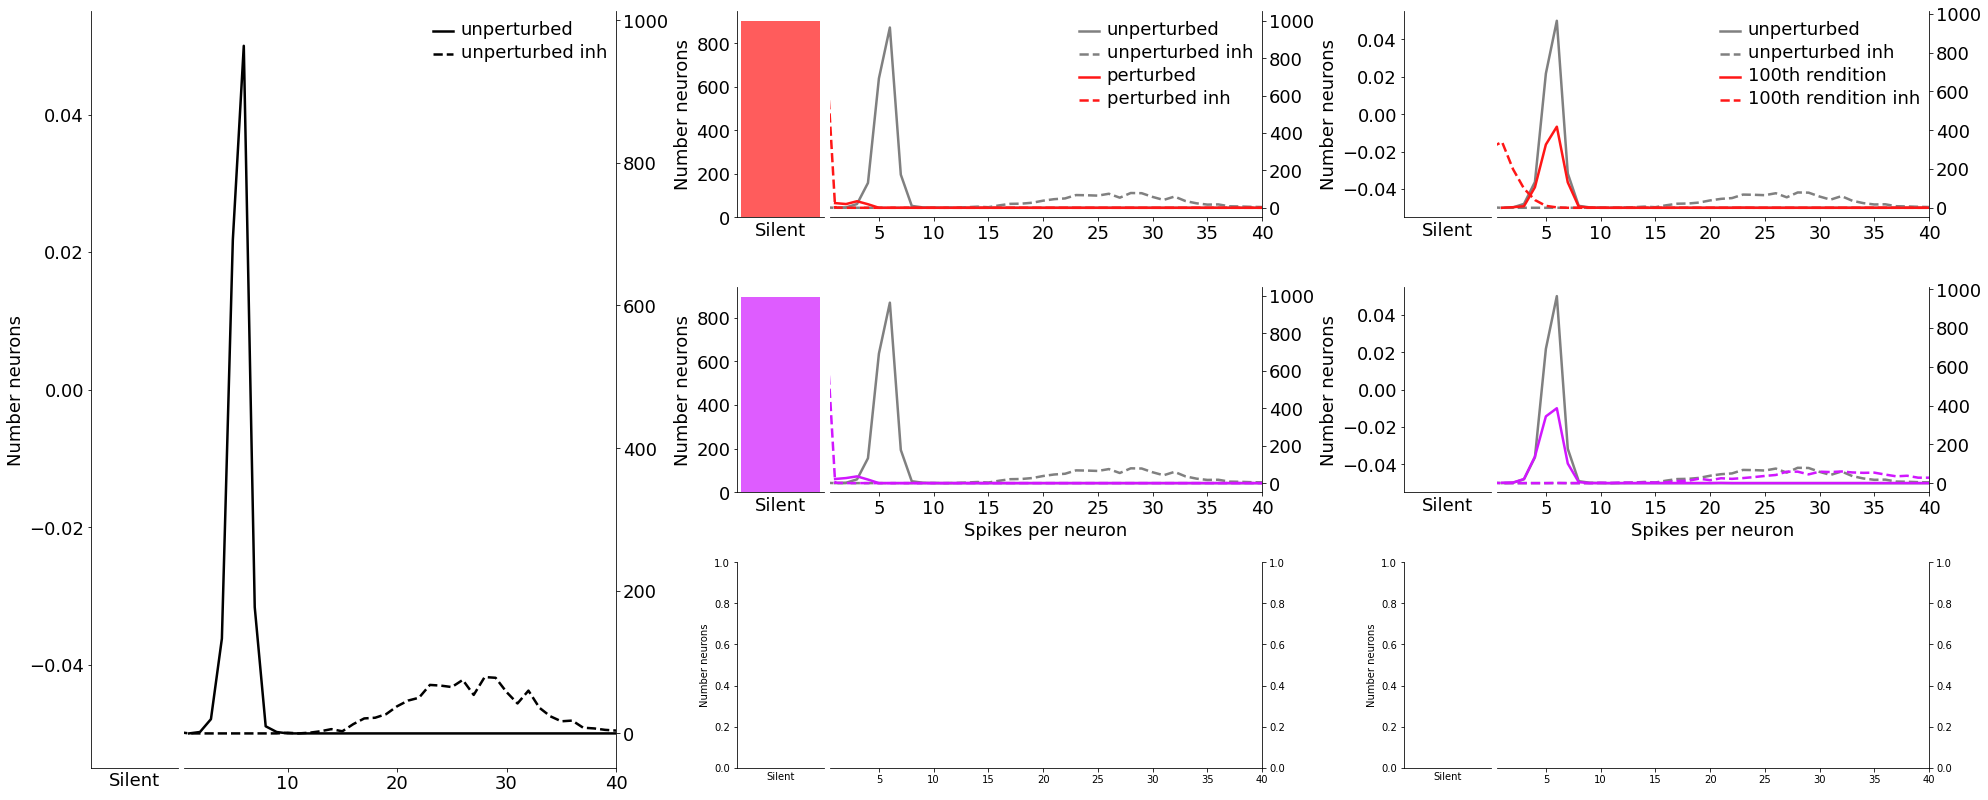

In [154]:
make_figure_3([
    fr_only_name_frags,
    two_single_cell_rules_name_frags,
], timepoints=[0, 13, 50], trials=np.arange(1))

(1) BTDP + single-cell firing rate upper bound + popopulation-level firing rate

(2) BTDP + population-level firing rate

(3) BTDP + single-cell rule (NOTE: single cell setpoints were artificial & silent cells were drawn in early)

In [134]:
def make_figure_4_averaged(names, labels, spaced_colors, dropout=0, file_name_ext='', ylim=(0, 8), cap=100):
    scale = 1.4
    fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(10 * scale, 7.5 * scale))
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    
    all_dirs = []
    for name in names:
        if type(name) is list:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        else:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])

    x = np.concatenate([np.ones(25) * (i/25) for i in range(0, 2000, 25)])
    
    for idx, exp_dir_names in enumerate(all_dirs):
        to_plot = ['pop_firing_rates', 'inh_pop_firing_rates', 'relative_prop_speeds', 'r_squareds', 'last_layer_actives']
        
        plot_data = {}
        for var in to_plot:
            plot_data[var] = {'raw': []}
        
        for j, exp_dir_name in enumerate(exp_dir_names):
            
            for var in to_plot:
                plot_data[var]['raw'].append([])

            for i, load_data in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=[f'dropout_{dropout}']):
                if i == cap:
                    break
                data = load_data()

                pop_firing_rate = np.sum(data['exc_cells_initially_active'])
                if data['exc_cells_newly_active'] is not None:
                    pop_firing_rate += np.sum(data['exc_cells_newly_active'])
                plot_data['pop_firing_rates']['raw'][-1].append(pop_firing_rate)
                
                inh_pop_firing_rate = np.sum(data['inh_raster'])
                plot_data['inh_pop_firing_rates']['raw'][-1].append(inh_pop_firing_rate)

                first_spk_times = data['first_spk_times']
                filtered_indices = data['surviving_cell_indices'] & (~np.isnan(first_spk_times))

                x_firing = x[filtered_indices]
                first_spk_times_nonnan = first_spk_times[filtered_indices]

                res = stats.linregress(first_spk_times_nonnan, x_firing)
                plot_data['relative_prop_speeds']['raw'][-1].append(res.slope)
                plot_data['r_squareds']['raw'][-1].append(np.square(res.rvalue))
                plot_data['last_layer_actives']['raw'][-1].append(data['last_layer_active'])
                
        for var in to_plot:
            plot_data[var]['means'] = safe_apply_stat(plot_data[var]['raw'], np.mean)
            plot_data[var]['stds'] = safe_apply_stat(plot_data[var]['raw'], np.std)
            plot_data[var]['sems'] = safe_apply_stat(plot_data[var]['raw'], lambda x: np.std(x) / np.sqrt(len(x)))
            
        epochs = np.arange(0, cap * 10, 10)
        
        axs[0, idx].fill_between(
            epochs,
            plot_data['pop_firing_rates']['means'] - plot_data['pop_firing_rates']['sems'],
            plot_data['pop_firing_rates']['means'] + plot_data['pop_firing_rates']['sems'],
            color=spaced_colors[idx], alpha=0.15
        )
        axs[0, idx].plot(epochs, plot_data['pop_firing_rates']['means'], c=spaced_colors[idx], lw=1., label=labels[idx])
        axs[0, idx].fill_between(
            epochs,
            plot_data['inh_pop_firing_rates']['means'] - plot_data['inh_pop_firing_rates']['sems'],
            plot_data['inh_pop_firing_rates']['means'] + plot_data['inh_pop_firing_rates']['sems'],
            color=spaced_colors[idx], alpha=0.15
        )
        line, = axs[0, idx].plot(epochs, plot_data['inh_pop_firing_rates']['means'], '-', c=spaced_colors[idx], lw=1., label=f'{labels[idx]} inh', )
        line.set_dashes([4, 4])
        axs[1, idx].fill_between(
            epochs,
            plot_data['relative_prop_speeds']['means'] - plot_data['relative_prop_speeds']['sems'],
            plot_data['relative_prop_speeds']['means'] + plot_data['relative_prop_speeds']['sems'],
            color=spaced_colors[idx], alpha=0.15
        )
        axs[1, idx].plot(epochs, plot_data['relative_prop_speeds']['means'], c=spaced_colors[idx], lw=1.)
        axs[2, idx].fill_between(
            epochs,
            plot_data['r_squareds']['means'] - plot_data['r_squareds']['sems'],
            plot_data['r_squareds']['means'] + plot_data['r_squareds']['sems'],
            color=spaced_colors[idx], alpha=0.15
        )
        axs[2, idx].plot(epochs, plot_data['r_squareds']['means'],c=spaced_colors[idx], lw=1.)
        axs[0, idx].set_ylim(0, 8e7)
        axs[1, idx].set_ylim(250, 500)
        axs[2, idx].set_ylim(0.6, 1.05)
        
    axs[0, 0].set_ylabel('Population spikes\nper activation')
    axs[1, 0].set_ylabel('Propagation speed (layers/s)')
    axs[2, 0].set_ylabel(r'$R^2$')
    
    axs[0, 2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
    for i in range(3):
        for j in range(3):
            axs[i, j].set_xlim(0, cap * 10)
            axs[i, 0].set_xlabel('Rendition number\n\n')
            set_font_size(axs[i, j], 16)
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.22, wspace=0.35)
    save_fig(fig, './figures/paper/fig_4', f'population_activity_+_prop_speed_{file_name_ext}.png')

## Figure 4: metrics of dynamics

### 50% dropout of HVC(RA) projectors

No handles with labels found to put in legend.


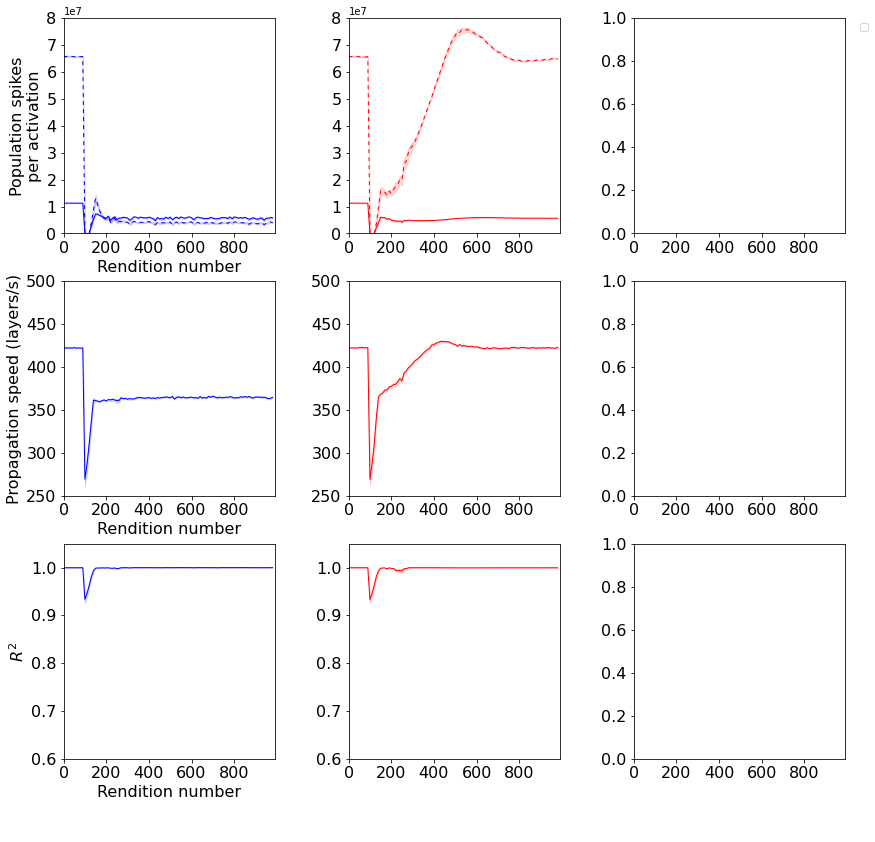

In [135]:
make_figure_4_averaged([
    fr_only_name_frags,
    two_single_cell_rules_name_frags,
], [
    'projector cell firing rate homeostasis',
    'projector cell and interneuron firing rate homeostasis',
], ['blue', 'red'], file_name_ext='both_rules', cap=99)

In [73]:
def make_figure_5(name, timepoints=[0, 50, 100, 170], color='black'):
    
    all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), [name])
    
    for exp_dir_name in sorted(all_dirs):
        scale = 1.1
        fig, axs = plt.subplots(2, 4, sharex=False, sharey=True, figsize=(15 * scale, 7.5 * scale))
        
        timepoint_names = [f'Rendition {t * 10}' for t in timepoints]
        j = 0
        for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name),
                                 name_frags=['dropout_0']):
            
            if j < len(timepoints) and i == timepoints[j]:
                summed_incoming_weights = data['summed_incoming_weights'].reshape(data['summed_incoming_weights'].shape[1])
                layer_weights = np.array([np.sum(summed_incoming_weights[i:i+20]) for i in range(0, summed_incoming_weights.shape[0], 20)])
                x = np.arange(summed_incoming_weights.shape[0])
                
                axs[0, j].scatter(x, summed_incoming_weights, s=1, c=color, zorder=0, alpha=1)
                axs[0, j].set_xlim(-1, 901)
                axs[0, j].set_xlabel('Cell Index')
                axs[0, j].set_ylabel('Summed Incoming Weights')
                axs[0, j].title.set_text(f'{timepoint_names[j]}')
                
                summed_incoming_weights_ei = data['summed_incoming_weights_e_i'].reshape(data['summed_incoming_weights_e_i'].shape[1])
                x_ei = np.arange(summed_incoming_weights_ei.shape[0])
                axs[1, j].scatter(x_ei, summed_incoming_weights_ei, s=1, c=color, zorder=0, alpha=1)

                axs[1, j].set_xlim(-1, 401)
                axs[1, j].set_xlabel('Cell Index')
                axs[1, j].set_ylabel('Summed Incoming Weights E->I')
                axs[1, j].title.set_text(f'{timepoint_names[j]}')
                
                for idx in range(2):
                    set_font_size(axs[idx, j], 16)
                j += 1
    
        fig.tight_layout()
#         save_fig(fig, './figures/paper/fig_1', f'{exp_dir_name}.png')

In [ ]:
make_figure_5('drop', timepoints=[0, 30, 50, 232])

In [137]:
def bernoulli_prob(n, k, p):
    return comb(n, k) * np.power(p, k) * np.power(p, n-k)    

def f(j, k, ks, n, m):
    if k == 0:
        return m / 0.3 * ks / (j + 0.3 * (n - j))
    else:
        return j/k * (k + 0.3 * ks) / (j + 0.3 * (n - j))

In [138]:
def calc_relative_increase(n_mean, m):
    tot = 0
    for n in range(2 * n_mean):
        for j in range(n):
            for k in range(j):
                for ks in range(n-j):
                    term = bernoulli_prob(2 * n_mean, n, 0.5) * bernoulli_prob(n, j, 0.5) * bernoulli_prob(j, k, 0.5) * bernoulli_prob(n-j, ks, 0.5) * f(j, k, ks, n, m)
                    tot += term
    return tot

In [141]:
all_data = []
for m in [1, 3, 10]:
    all_data.append([calc_relative_increase(n, m) for n in range(10, 30)])

Text(0, 0.5, 'Relative mean synaptic weight per cell')

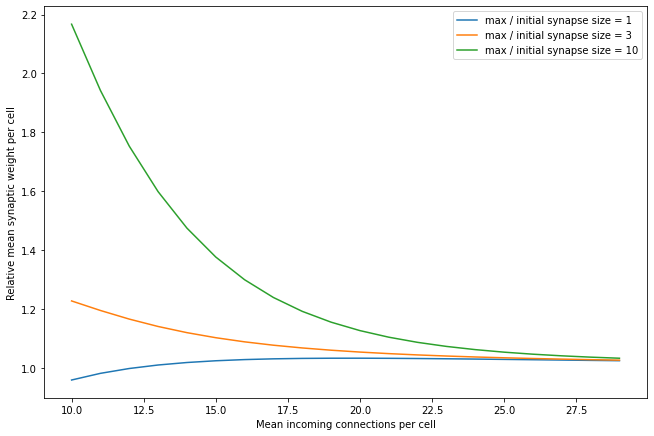

In [143]:
fig, axs = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6 * scale, 4 * scale))
for j, m in enumerate([1, 3, 10]):
    axs.plot(range(10, 30), all_data[j], label=f'max / initial synapse size = {m}')
axs.legend()
axs.set_xlabel('Mean incoming connections per cell')
axs.set_ylabel('Relative mean synaptic weight per cell')